<h2>Data Manipulation</h2>

In order to start the data analysis, we will need to import a variety of packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

We will read in the data, which was downloaded from the Airbnb website and look at its info.

In [2]:
# Read in data
dat = pd.read_csv('datas/listings.csv')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6455 entries, 0 to 6454
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6455 non-null   int64  
 1   listing_url                                   6455 non-null   object 
 2   scrape_id                                     6455 non-null   int64  
 3   last_scraped                                  6455 non-null   object 
 4   name                                          6455 non-null   object 
 5   description                                   6441 non-null   object 
 6   neighborhood_overview                         4703 non-null   object 
 7   picture_url                                   6455 non-null   object 
 8   host_id                                       6455 non-null   int64  
 9   host_url                                      6455 non-null   o

We can see that there are 74 columns, and 6,366 observations, however some values are missing in various columns.

In [3]:
test = dat['calendar_last_scraped'] == dat['last_scraped']

In [4]:
test.unique()

array([ True, False])

<h2>Data Cleansing</h2>

<h4>Drop off irrelevant columns:</h4>

* URLs will not be useful
* Empty columns: 'neighborhood_group_cleansed', 'bathrooms', 'calendar_updated'
* 'neighborhood' column only has blank values or 'Chicago, Illinois, United States' value, making it useless
* Drop 'host_listings_count' and 'host_total_listings_count', use the calculated_host_listings columns
* 'scrape_id' is all the same value and not useful for our needs
* 'calendar_last_scraped' can be dropped (same value as 'last_scraped')

In [5]:
dat = dat.drop(['scrape_id','listing_url','host_url','host_thumbnail_url','host_picture_url','picture_url',
               'neighbourhood_group_cleansed','bathrooms','calendar_updated','neighbourhood',
               'calendar_last_scraped','host_listings_count'], axis = 1)

<h4>Bathrooms Column:</h4>

In [6]:
dat = dat.rename(columns={'id':'property_id', 'bathrooms_text':'bathrooms'})

In [7]:
dat['bathrooms'].unique()

array(['1 shared bath', '1 bath', '1 private bath', '2 baths',
       '1.5 shared baths', '1.5 baths', '3 baths', '2 shared baths',
       '2.5 baths', '0 baths', '3.5 baths', '11 shared baths', nan,
       '0 shared baths', '2.5 shared baths', 'Private half-bath',
       '3 shared baths', '4 baths', '5 baths', 'Shared half-bath',
       '4.5 baths', '11.5 shared baths', '4 shared baths', '6.5 baths',
       '7 baths', '5.5 baths', '6 baths', 'Half-bath', '8 shared baths',
       '12.5 baths', '10 baths', '7.5 baths'], dtype=object)

Looking at the 'bathrooms_text' column, we see that it is not very usable in its current state.  We will split the bathroom text column into two: one containing a float variable for the number of bathrooms, and the other an additional descriptor of the bathroom (shared/private).

In [8]:
# First let us make all text lowercase to simplify string manipulation
# dat['bathrooms'] = dat['bathrooms'].str.lower()

# Next we must convert any text 'half' to 0.5 so it is included in the subsequent number extraction
#dat['bathrooms'] = dat['bathrooms'].str.replace(r'(half)+','0.5', regex = True)

# Then extract the numbers into the new 'bathrooms' float32 data type column
#dat['bathrooms'] = dat['bathrooms'].str.extract(r'(\d+\.?\d*)', expand = True).astype(np.float32)

# This leaves us with only float and NaN values
#dat['bathrooms'].unique()
# First let us split the text by white space
bath = dat['bathrooms'].str.split(' ', expand = True)
bath

,0,1,2
0,1,shared,bath
1,1,bath,None
2,1,bath,None
3,1,bath,None
4,1,private,bath
...,...,...,...
6450,1,bath,None
6451,1,bath,None
6452,1,bath,None
6453,1,bath,None


In [9]:
# then drop column 1 and 2, keep column 0
bath = bath.drop([1,2], axis=1)
dat['bathrooms'] = bath[0].replace(['Private', 'Shared', 'Half-bath'], '0.5')
dat['bathrooms'] = dat['bathrooms'].astype('float')
dat['bathrooms'].unique()

array([ 1. ,  2. ,  1.5,  3. ,  2.5,  0. ,  3.5, 11. ,  nan,  0.5,  4. ,
        5. ,  4.5, 11.5,  6.5,  7. ,  5.5,  6. ,  8. , 12.5, 10. ,  7.5])

Above are the unique values left for the float variable in the column 'bathrooms'.

In [10]:
dat['bathrooms'].value_counts()

1.0     4504
2.0     1145
1.5      285
2.5      184
3.0      134
3.5       72
4.0       52
4.5       19
0.0       13
6.0        9
0.5        9
5.0        8
11.0       4
7.0        3
6.5        2
11.5       1
5.5        1
8.0        1
12.5       1
10.0       1
7.5        1
Name: bathrooms, dtype: int64

This leaves us with only 1,587 observations with one of the bathroom descriptors, 'shared' or 'private'; the rest are missing values since the original data did not contain text for them.

<h4>DateTime Columns:</h4>

Next, let's convert the datetime columns into the proper datatype.

In [11]:
# Convert dates to datetime data type
for x in ['last_scraped', 'host_since', 'first_review', 'last_review']:
    dat[x] = pd.to_datetime(dat[x])

**Create a new column to get how long the host exist**

In [12]:
dat['host_period'] = dat['last_scraped'] - dat['host_since']

<h4>Rate Columns:</h4>

In [13]:
dat['host_response_rate'].sample(5)

1466     NaN
1113    100%
519     100%
2656     75%
3281    100%
Name: host_response_rate, dtype: object

We can see that we will need to convert the percentage columns ('host_response_rate' and 'host_acceptance_rate') into float variables.

In [14]:
# Convert host response rate and acceptance rate columns into float

dat['host_response_rate'] = dat['host_response_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_acceptance_rate'] = dat['host_acceptance_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_response_rate'].sample(5)

2560    0.80
888      NaN
3497    0.90
3929    0.00
313     0.91
Name: host_response_rate, dtype: float32

<h4>Boolean Columns:</h4>

In [15]:
dat['host_is_superhost'].unique()

array(['t', 'f', nan], dtype=object)

We will convert the 't' and 'f' values to binary float values for later analysis, where 1 will mean "True".

In [16]:
# Map superhost column to boolean values
def repl_f_t(l):
    l = l.replace('f', 0)
    l = l.replace('t', 1);
    return l
dat['host_is_superhost'] = repl_f_t(dat['host_is_superhost']).astype('float');
dat['host_identity_verified'] = repl_f_t(dat['host_identity_verified']).astype('float')
dat['instant_bookable'] = repl_f_t(dat['instant_bookable']).astype('float')
dat['host_has_profile_pic'] = repl_f_t(dat['host_has_profile_pic']).astype('float')
dat['has_availability'] = repl_f_t(dat['has_availability']).astype('float')

#dat['host_is_superhost'] = dat['host_is_superhost'].map({'t':1,'f':0}).astype('float')
#dat['host_has_profile_pic'] = dat['host_has_profile_pic'].map({'t':1,'f':0}).astype('float')
#dat['host_identity_verified'] = dat['host_identity_verified'].map({'t':1,'f':0}).astype('float')
#dat['has_availability'] = dat['has_availability'].map({'t':1,'f':0}).astype('float')
#dat['instant_bookable'] = dat['instant_bookable'].map({'t':1,'f':0}).astype('float')

In [17]:
dat['host_is_superhost']

0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
6450    0.0
6451    0.0
6452    1.0
6453    1.0
6454    1.0
Name: host_is_superhost, Length: 6455, dtype: float64

<h4>Price Column:</h4>

Convert the price column to a float data type.

In [18]:
dat['price'] = dat['price'].str.extract(r'(\d+\.\d+)').astype(np.float64)

In [19]:
dat['price'].sample(5)

2933     30.0
2601     85.0
6387     54.0
1896    140.0
2893    165.0
Name: price, dtype: float64

In [20]:
dat['license'].sample(20)

6221                 R21000026918
3379                 R19000043826
2505                 R20000055627
2382    City registration pending
2157    City registration pending
1739                 R20000053583
1386    City registration pending
1283    City registration pending
308                  R17000015165
4496                 R20000057877
3230    City registration pending
2028                 R18000026638
6316                 R20000059104
870     City registration pending
3311                 R19000044998
2035                 R19000042280
220     City registration pending
4696                 R20000057682
5421                 R19000057891
3837                      2647001
Name: license, dtype: object

It does not seem that the license column will be useful so we will drop it from the dataset.

In [21]:
dat = dat.drop(['license'], axis=1)

**Remove duplicate rows from dataset**

In [22]:
dat = dat.drop_duplicates()

In [23]:
dat = dat.loc[:,~dat.columns.duplicated()]
dat.head()

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period
0,2384,2021-09-17,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,...,4.98,4.95,4.94,0.0,1,0,1,0,2.42,4767 days
1,7126,2021-09-17,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,...,4.86,4.87,4.72,0.0,1,1,0,0,3.29,4504 days
2,10945,2021-09-16,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",...,4.70,4.97,4.58,1.0,4,4,0,0,0.37,4409 days
3,12068,2021-09-16,Chicago GOLD COAST 1 Bedroom Condo,Available as extended stay rental located in C...,The condo is on Lasalle just off of Division; ...,40731,Dominic,2009-09-23,"New York, New York, United States",NYC,...,4.75,4.75,4.75,0.0,1,1,0,0,0.15,4376 days
4,12140,2021-09-17,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Sharon And Robert,2009-10-18,"Chicago, Illinois, United States",Best in the city with long-time urban-dwelling...,...,5.00,5.00,5.00,0.0,1,0,1,0,0.09,4352 days


**Dummy Variable**

In [24]:
x = pd.get_dummies(dat['host_is_superhost'])
dat = pd.concat([dat,x], axis=1)
dat = dat.rename(columns={0.0:'host_is_superhost_f', 1.0:'host_is_superhost_t'})

In [25]:
x1 = pd.get_dummies(dat['host_identity_verified'])
dat = pd.concat([dat,x1], axis=1)
dat = dat.rename(columns={0.0:'host_identity_verified_f', 1.0:'host_identity_verified_t'})

In [26]:
x2 = pd.get_dummies(dat['instant_bookable'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'instant_bookable_f', 1.0:'instant_bookable_t'})

In [27]:
x2 = pd.get_dummies(dat['host_has_profile_pic'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'host_has_profile_pic_f', 1.0:'host_has_profile_pic_t'})

In [28]:
x2 = pd.get_dummies(dat['has_availability'])
dat = pd.concat([dat,x2], axis=1)
dat = dat.rename(columns={0.0:'has_availability_f', 1.0:'has_availability_t'})

In [29]:
dat.drop(['host_is_superhost_f', 'host_identity_verified_f', 'instant_bookable_f', 'host_has_profile_pic_f', 'has_availability_f'],axis=1).head()

,property_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_period,host_is_superhost_t,host_identity_verified_t,instant_bookable_t,host_has_profile_pic_t,has_availability_t
0,2384,2021-09-17,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,...,0,1,0,2.42,4767 days,1,1,0,1,1
1,7126,2021-09-17,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,...,1,0,0,3.29,4504 days,1,1,0,1,1
2,10945,2021-09-16,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",...,4,0,0,0.37,4409 days,1,1,1,1,1
3,12068,2021-09-16,Chicago GOLD COAST 1 Bedroom Condo,Available as extended stay rental located in C...,The condo is on Lasalle just off of Division; ...,40731,Dominic,2009-09-23,"New York, New York, United States",NYC,...,1,0,0,0.15,4376 days,0,1,0,1,1
4,12140,2021-09-17,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Sharon And Robert,2009-10-18,"Chicago, Illinois, United States",Best in the city with long-time urban-dwelling...,...,0,1,0,0.09,4352 days,0,1,0,1,1


**Missing value**

<h2>Data Exploration and Visualization</h2>

Let us explore the data in the dataset.

<h4>Unique Hosts</h4>

First, how many unique hosts are there?

In [30]:
dat['host_id'].nunique()

3387

In [31]:
listings_by_host = dat['host_id'].value_counts()
listings_by_host.describe()

count    3387.000000
mean        1.905816
std         5.864561
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       283.000000
Name: host_id, dtype: float64

In [32]:
listings_by_host[listings_by_host > 1].count()

812

Here we can see that out of the 3,371 unique hosts, 799 have more than one listing in the Chicago area.  Interestingly, there is one host id with 260 listings.

Let's graph this data to see the distribution of hosts with differing numbers of listings.

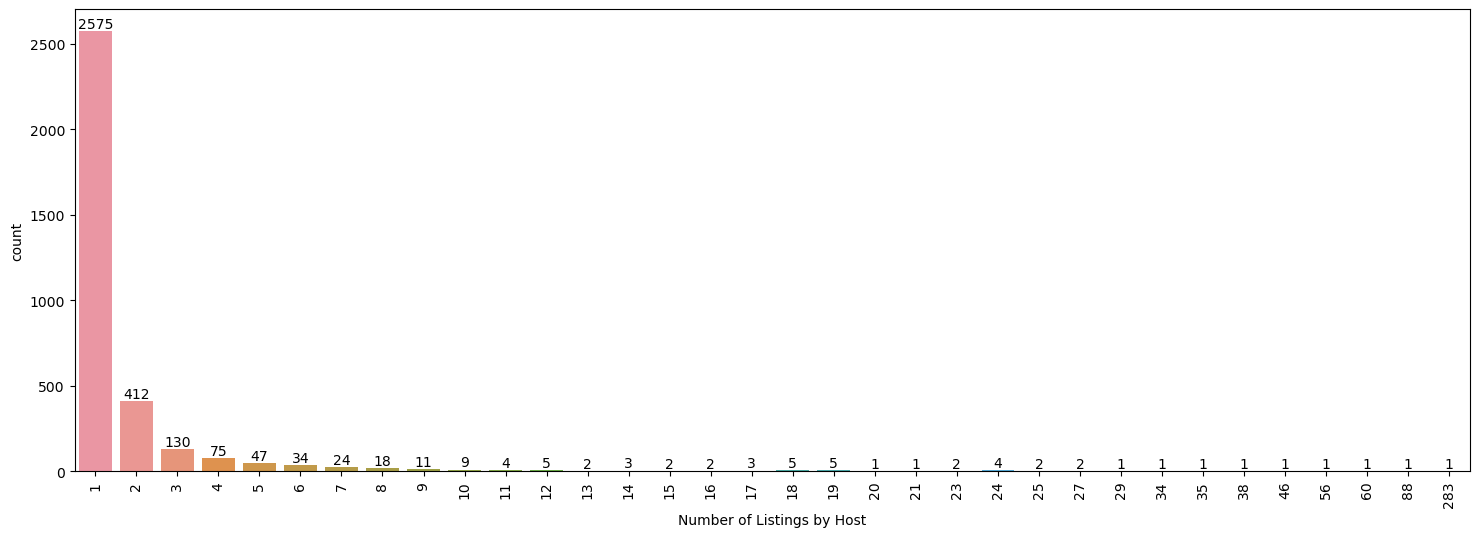

In [33]:
plt.figure(figsize=(18,6))
p = sb.countplot(x=listings_by_host, order=sorted(listings_by_host.unique()))
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
p.bar_label(p.containers[0])
plt.xlabel('Number of Listings by Host')
plt.show()

It is obvious that a vast majority of hosts have only one listing in the Chicago area.

<h4>Host Response Time</h4>


In [34]:
dat['host_response_time'].unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

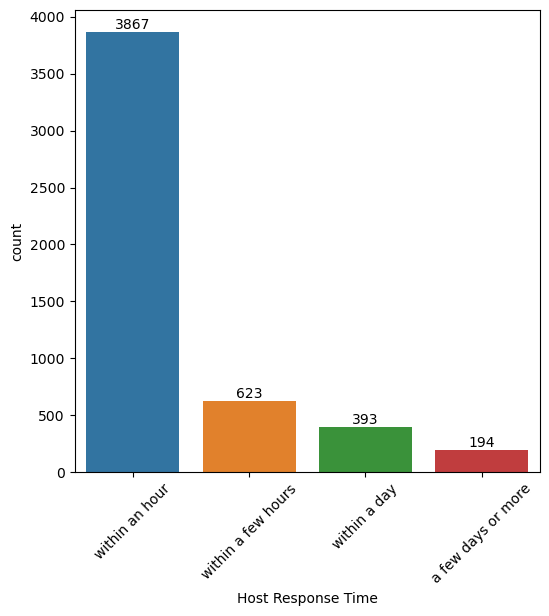

In [35]:
plt.figure(figsize=(6,6))
p = sb.countplot(x='host_response_time',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=45)
p.bar_label(p.containers[0])
plt.xlabel('Host Response Time')
plt.show()

Here we can see there are four categories for the response time.  Let's define a system for rating the response time by using floating numbers.  We will assign the values in hours and as follows:
 * 'within an hour' = 1 hour
 * 'within a few hours' = 5 hours
 * 'within a day' = 24 hours
 * 'a few days or more' = 48 hours

In [36]:
dat['host_response_time_float'] = dat['host_response_time'].map({'within an hour':1,'within a few hours':5,
                                                           'within a day':24,'a few days or more':48}).astype(np.float32)
dat['host_response_time_float'].unique()

array([ 1.,  5., nan, 24., 48.], dtype=float32)

<h4>Host Verifications</h4>

In order to simplify future analysis, let us count the number of verifications the host has and list this in a new column.

In [37]:
dat['host_verifications'].sample(5)

3750                                            ['phone']
2106    ['email', 'phone', 'facebook', 'reviews', 'off...
4972                                            ['email']
4739    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1607    ['email', 'phone', 'reviews', 'jumio', 'offlin...
Name: host_verifications, dtype: object

We can see that the verifications are separated by a comma, so we will use this to count the number of verifications each host has.

In [38]:
dat['no_of_verif'] = dat['host_verifications'].str.count(r',') + 1
dat.loc[:, ['host_verifications','no_of_verif']].head()

,host_verifications,no_of_verif
0,"['email', 'phone', 'reviews', 'manual_offline'...",6
1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",8
2,"['email', 'phone', 'reviews', 'jumio', 'govern...",6
3,"['email', 'phone', 'reviews', 'offline_governm...",7
4,"['email', 'phone', 'facebook', 'reviews', 'kba']",5


In order to catch any observations where hosts have no verifications, we will set the number of verifications to zero where the host_verifications = 'None'.  This is important since the code above would have counted 'none' and an observation without a comma (i.e. only one verification) as 1.

In [39]:
dat['no_of_verif'] = np.where(dat['host_verifications'] == 'None', 0, dat['no_of_verif'])

In [40]:
dat['no_of_verif'].describe()

count    6455.000000
mean        5.515414
std         2.350264
min         0.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        12.000000
Name: no_of_verif, dtype: float64

On average, hosts have about 5-6 different identity verifications. 

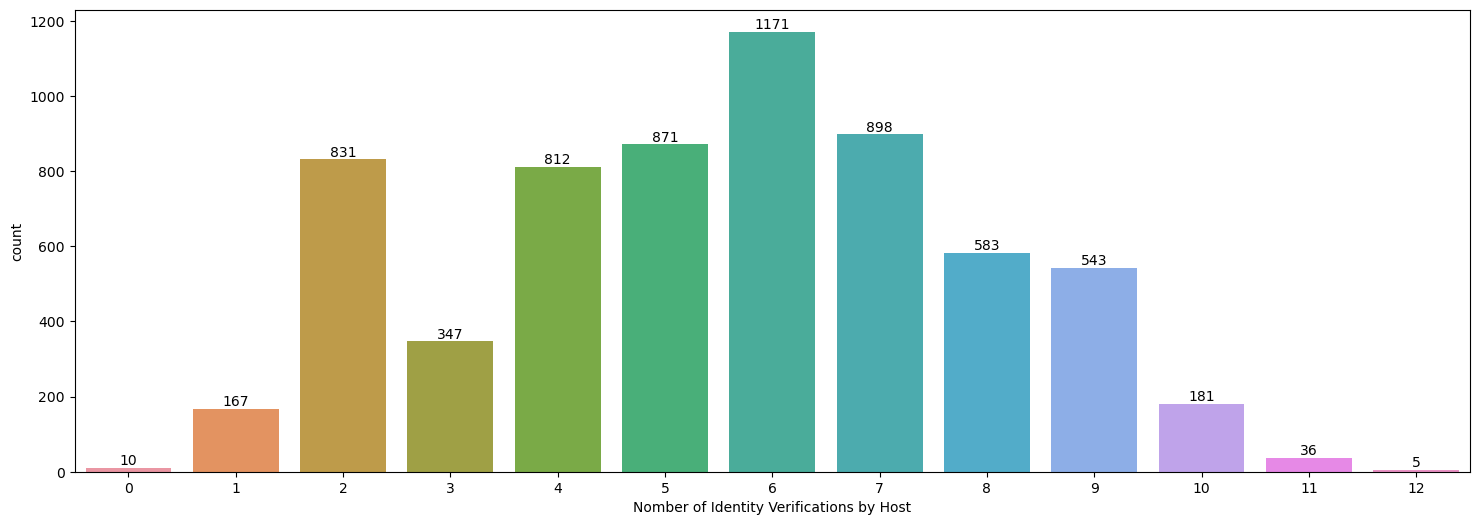

In [41]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_verif',data = dat)
p.bar_label(p.containers[0])
plt.xlabel('Nomber of Identity Verifications by Host')
plt.show()

<h4>Amenities</h4>

Repeat the same process for number of amenities listed.

In [42]:
dat['no_of_amen'] = dat['amenities'].str.count(r',') + 1
dat.loc[:, ['amenities','no_of_amen']].head()

,amenities,no_of_amen
0,"[""Refrigerator"", ""Microwave"", ""Body soap"", ""Fr...",52
1,"[""Refrigerator"", ""Microwave"", ""Wifi"", ""Room-da...",30
2,"[""Refrigerator"", ""Microwave"", ""Wifi"", ""Heating...",33
3,"[""Refrigerator"", ""Microwave"", ""Wifi"", ""Heating...",31
4,"[""Lock on bedroom door"", ""Wifi"", ""Heating"", ""C...",22


In [43]:
dat['no_of_amen'].describe()

count    6455.000000
mean       31.811464
std        11.159280
min         1.000000
25%        24.000000
50%        31.000000
75%        38.000000
max        83.000000
Name: no_of_amen, dtype: float64

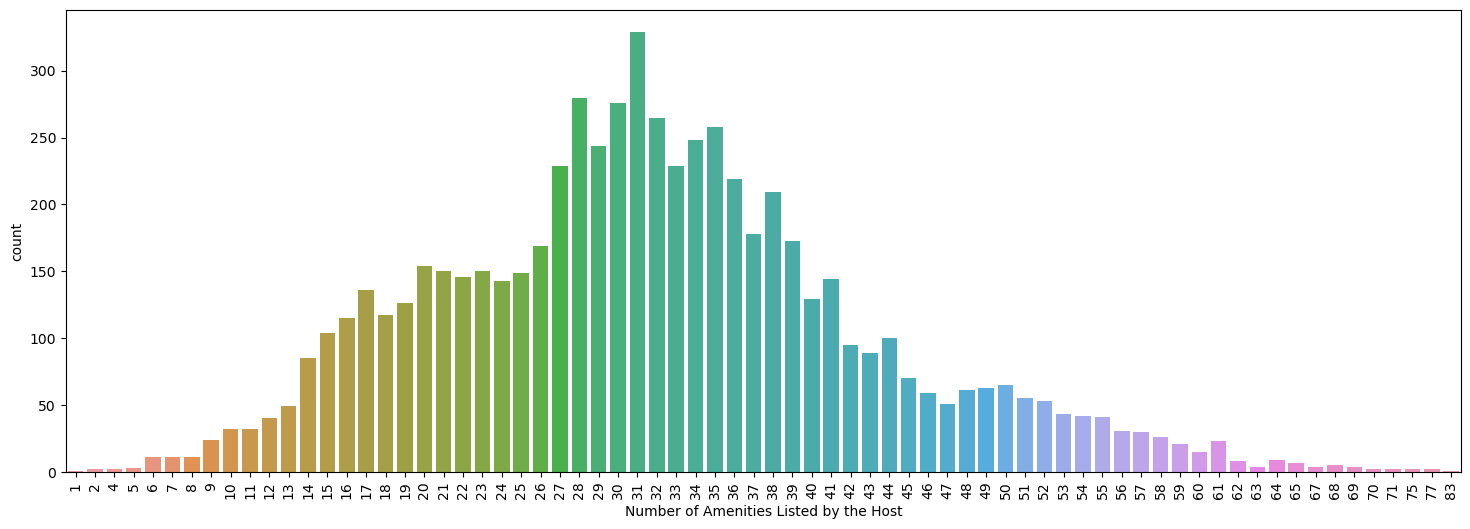

In [44]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_amen',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

<h4>Distance from Center of Chicago</h4>

Let's calculate the distance of the listing from the center of the city of Chicago.  We will use the following coordinates: 41.8781° N, 87.6298° W (source needed?).

We will use the Haversine formula to calculate the distance in miles.  In order to do so, we will first define a function to perform the calculation.

In [45]:
# Coordinates for center of Chicago in degrees
lat1 = 41.8781
long1 = -87.6298

# Constant, radius of the Earth in miles
r = 3958.8

# Define a function to calculate the distance
def haversine(lat2, long2):
    # First convert degrees into radians:
    rlat1 = lat1 * (math.pi / 180)
    rlat2 = lat2 * (math.pi / 180)
    rlong1 = long1 * (math.pi / 180)
    rlong2 = long2 * (math.pi / 180)
    
    # Calculate the differnce between the latitudes and longitudes
    dlat = rlat1 - rlat2
    dlong = rlong1 - rlong2
    
    # Use the Haversine formula (broken into 3 terms for simplification here)
    a = (math.sin(dlat / 2) ** 2)         # First term
    b = math.cos(rlat1) * math.cos(rlat2) # Second term
    c = (math.sin(dlong / 2) ** 2)        # Third term
    e = math.sqrt(a + b * c)
    d = 2 * r * e                         # where r is the radius of the Earth
    return d

Then, apply the formula to each observation in the data set, returning the answer in a new column for the distance from the center of the city.

In [46]:
dat['d_center'] = dat.apply(
    lambda row: haversine(row['latitude'], row['longitude']),
    axis=1)
dat['d_center'].sample(5)

4755    2.079603
4473    5.022010
2544    2.592977
6110    1.063605
5510    3.596598
Name: d_center, dtype: float64

In [47]:
dat['d_center'].describe()

count    6455.000000
mean        4.276235
std         2.720132
min         0.010381
25%         1.915995
50%         3.950317
75%         5.952490
max        16.372642
Name: d_center, dtype: float64

In order to visualize the distances, let us plot them against the listing price values.

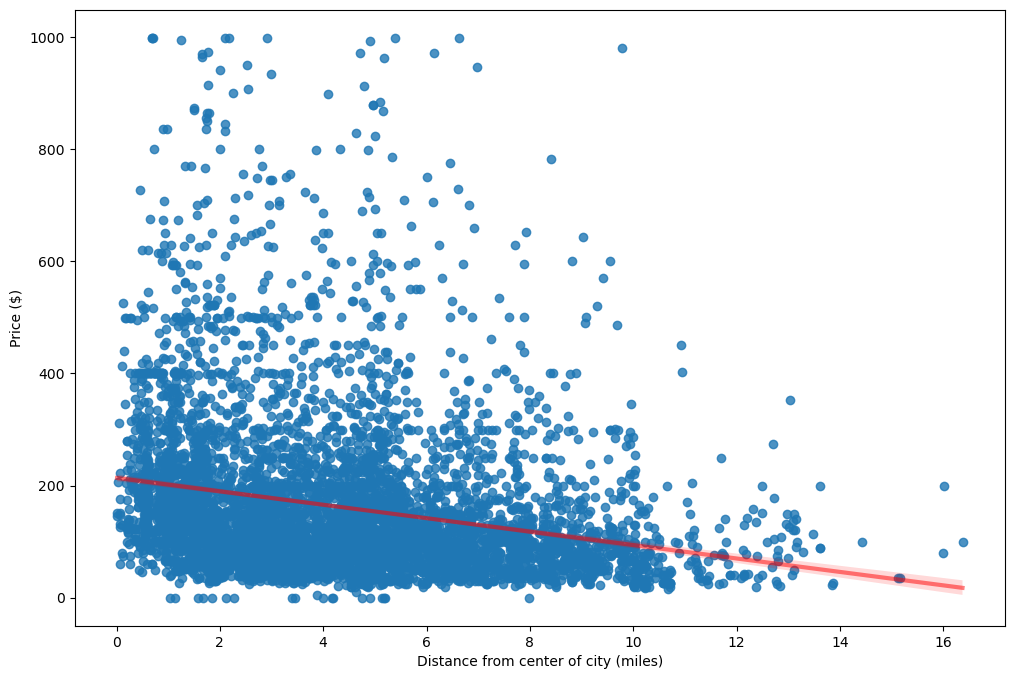

In [48]:
plt.figure(figsize=(12,8))
sb.regplot(x="d_center", y="price", 
            line_kws={"color":"r","alpha":0.5,"lw":3}, data=dat)
plt.xlabel('Distance from center of city (miles)')
plt.ylabel('Price ($)')
plt.show()

On first look, it appears that the listings further from the city are less valuable on average.

<h4>Property and Room Types</h4>

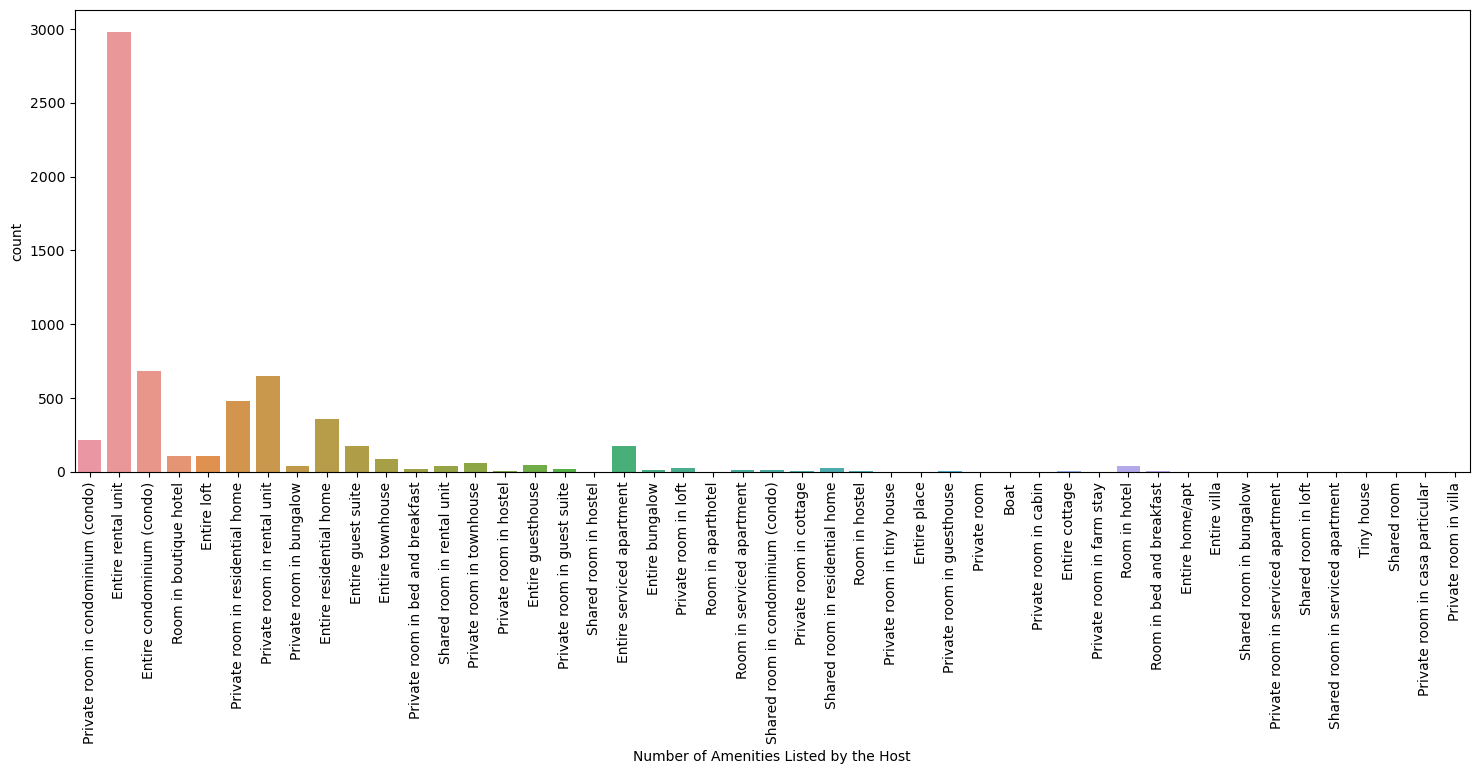

In [49]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='property_type',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

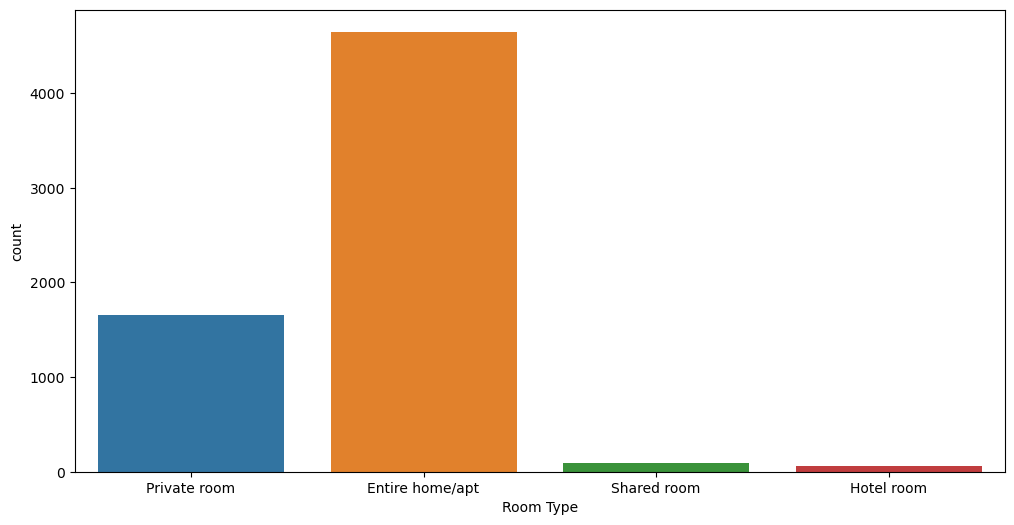

In [50]:
plt.figure(figsize=(12,6))
p = sb.countplot(x='room_type',data = dat)
plt.xlabel('Room Type')
plt.show()

<h2>Dimension Reduction</h2>



In [51]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6455 entries, 0 to 6454
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype          
---  ------                                        --------------  -----          
 0   property_id                                   6455 non-null   int64          
 1   last_scraped                                  6455 non-null   datetime64[ns] 
 2   name                                          6455 non-null   object         
 3   description                                   6441 non-null   object         
 4   neighborhood_overview                         4703 non-null   object         
 5   host_id                                       6455 non-null   int64          
 6   host_name                                     6445 non-null   object         
 7   host_since                                    6445 non-null   datetime64[ns] 
 8   host_location                                 6435 non-nul

In order to complete a Principal Component Analysis, we need to only select the numeric values and drop values with NaNs.

In [52]:
# Select only numeric values
dat_pre_norm = dat.loc[:,['host_response_rate','host_acceptance_rate','host_is_superhost',
                         'host_total_listings_count','host_has_profile_pic',
                          'host_identity_verified','latitude','longitude','accommodates','bedrooms','beds',
                         'price','minimum_minimum_nights','maximum_minimum_nights',
                         'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                         'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                         'review_scores_checkin','review_scores_communication','review_scores_location',
                         'review_scores_value','reviews_per_month']]
dat_pre_norm = dat_pre_norm.dropna()

In [53]:
dat_norm = scale(dat_pre_norm)

For the fist PCA, we will include all of the variables (i.e. columns from the selection above).

In [54]:
pca1 = PCA(n_components=len(dat_pre_norm.columns))

pca1.fit(dat_norm)

PCA(n_components=29)

In [55]:
var = pca1.explained_variance_ratio_
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
print(var1)

[ 18.65  30.41  41.47  51.14  59.42  64.55  69.1   72.72  76.08  79.21
  81.98  84.57  87.07  89.05  90.84  92.5   94.13  95.22  96.18  96.98
  97.71  98.34  98.91  99.45  99.81 100.01 100.01 100.01 100.01]


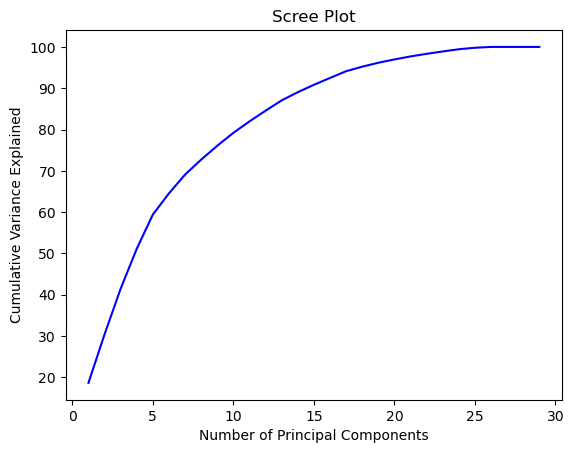

In [56]:
var1 = pd.DataFrame(var1, index=np.arange(1,int(len(dat_pre_norm.columns))+1))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

Taking the first 18 principal components will correspond to 90% of the variance explained.

In [57]:
pca18 = PCA(n_components=18)
pca18.fit(dat_norm)
data_pca18 = pca18.transform(dat_norm)

# Convert the numpy array to pandas DataFrame
data_pca18 = pd.DataFrame(data_pca18)
data_pca18.columns = ["PC"+str(i) for i in range(1,19)]

In [58]:
data_pca18.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
PC1,1.000000e+00,2.132379e-16,-2.614575e-17,1.007127e-16,1.859592e-17,2.590615e-16,3.647910e-16,-4.687683e-17,3.117387e-17,2.161876e-18,-2.927543e-16,8.582198e-17,1.465686e-16,1.543781e-16,4.470919e-16,7.407287e-17,2.814733e-16,6.059999e-16
PC2,2.132379e-16,1.000000e+00,8.618579e-17,1.689336e-15,-6.978528e-17,3.319614e-16,4.200639e-16,-1.477037e-16,2.130682e-16,-1.103738e-16,6.404325e-17,-3.785577e-16,-2.773173e-16,-2.624337e-16,-6.474612e-16,-1.007209e-16,-1.939501e-16,1.309521e-16
PC3,-2.614575e-17,8.618579e-17,1.000000e+00,1.599902e-15,3.588774e-16,4.171528e-16,-2.062127e-16,-2.986952e-16,1.229979e-16,-2.675657e-16,1.820733e-18,-1.840759e-16,-1.750706e-16,-5.632963e-17,2.293196e-16,2.114023e-16,-1.588458e-16,3.307292e-16
PC4,1.007127e-16,1.689336e-15,1.599902e-15,1.000000e+00,8.031048e-16,1.275212e-16,-3.518172e-16,-1.382725e-17,-7.427162e-17,-4.502705e-16,-3.207509e-16,-1.692917e-16,-4.612172e-16,-1.452396e-16,1.378039e-16,2.936097e-16,-1.853867e-16,4.836017e-18
PC5,1.859592e-17,-6.978528e-17,3.588774e-16,8.031048e-16,1.000000e+00,3.481547e-16,-2.234183e-16,-7.260238e-16,-8.916860e-17,9.859120e-18,-2.057153e-16,3.535293e-16,-2.011319e-17,1.010125e-16,-4.004370e-16,-3.345176e-17,-1.936537e-16,-3.199250e-16
PC6,2.590615e-16,3.319614e-16,4.171528e-16,1.275212e-16,3.481547e-16,1.000000e+00,3.216099e-16,-3.461761e-18,2.219530e-16,-8.839254e-17,1.640170e-16,3.009820e-18,3.774914e-16,6.732053e-17,2.482618e-16,1.010865e-16,-1.964965e-16,2.416319e-16
PC7,3.647910e-16,4.200639e-16,-2.062127e-16,-3.518172e-16,-2.234183e-16,3.216099e-16,1.000000e+00,8.133903e-15,5.595504e-16,1.751996e-16,-6.271096e-16,4.673517e-17,3.613934e-16,1.438035e-16,5.816609e-17,-4.143050e-17,6.772155e-16,-8.009249e-17
PC8,-4.687683e-17,-1.477037e-16,-2.986952e-16,-1.382725e-17,-7.260238e-16,-3.461761e-18,8.133903e-15,1.000000e+00,1.462229e-16,1.352858e-16,6.773410e-16,-1.521705e-16,9.464537e-17,1.174213e-16,-1.681811e-16,-7.712207e-17,2.473319e-16,-3.834427e-16
PC9,3.117387e-17,2.130682e-16,1.229979e-16,-7.427162e-17,-8.916860e-17,2.219530e-16,5.595504e-16,1.462229e-16,1.000000e+00,-6.355355e-16,-1.382797e-15,2.162805e-16,6.540144e-16,-1.203371e-15,-3.788579e-16,1.102922e-16,-2.070311e-16,6.417563e-17
PC10,2.161876e-18,-1.103738e-16,-2.675657e-16,-4.502705e-16,9.859120e-18,-8.839254e-17,1.751996e-16,1.352858e-16,-6.355355e-16,1.000000e+00,9.096768e-16,2.399713e-16,7.531963e-16,1.396623e-16,-4.266407e-16,9.916328e-17,1.498345e-16,-1.750485e-16


From the above correlation table, we can find that the pairwise correlations between two components are close to zeros. This means that all these components are orthogonal (not correlated). There is no multicollinearity among principal components.